# NGC 2403

In [5]:
import numpy as np
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from astropy.io import fits
import astropy.units as u
from astropy.nddata import Cutout2D
from astropy.wcs.utils import pixel_to_skycoord, skycoord_to_pixel
from astropy.utils.data import get_pkg_data_filename
from IPython.display import Image
from scipy.optimize import curve_fit
from matplotlib.gridspec import GridSpec
import pandas as pd
from astroquery.ned import Ned
import matplotlib.patches as mpatches
from shapely.geometry import Point, LineString
from shapely.geometry.polygon import Polygon
import shapely
import matplotlib.pyplot as mpl

In [6]:
import matplotlib.pyplot as plt
plt.style.use('classic')
import matplotlib
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('font',**{'family':'serif','serif':['PT Serif']})
rc('text', usetex=True)
matplotlib.rcParams['ps.useafm'] = True
matplotlib.rcParams['pdf.use14corefonts'] = True
matplotlib.rcParams['text.usetex'] = True

In [7]:
Mpc = 3.22
incl=60

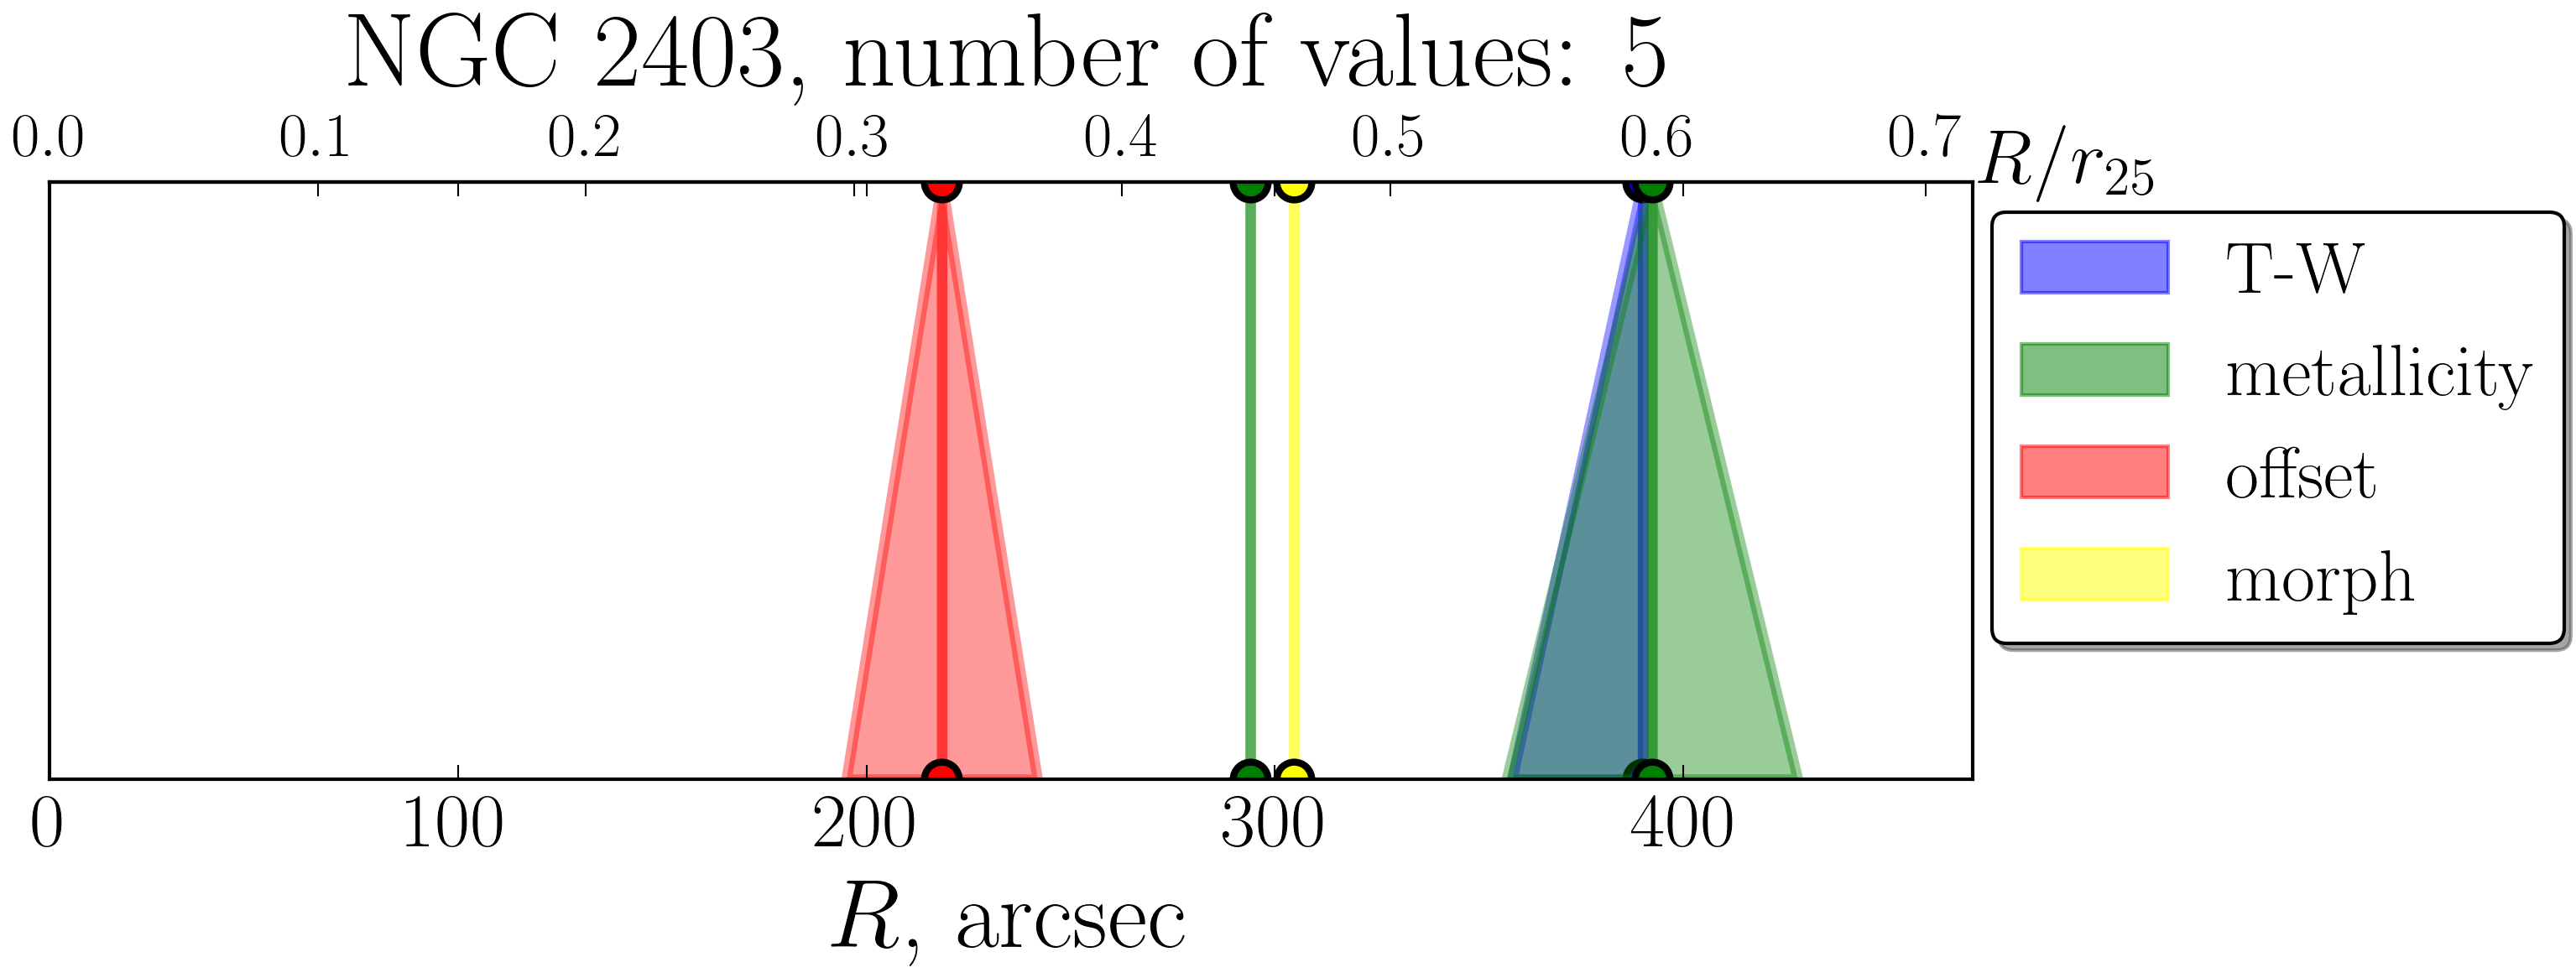

In [8]:
Image('./../CR_distributions/NGC 2403.png', width=800)

### F-B method

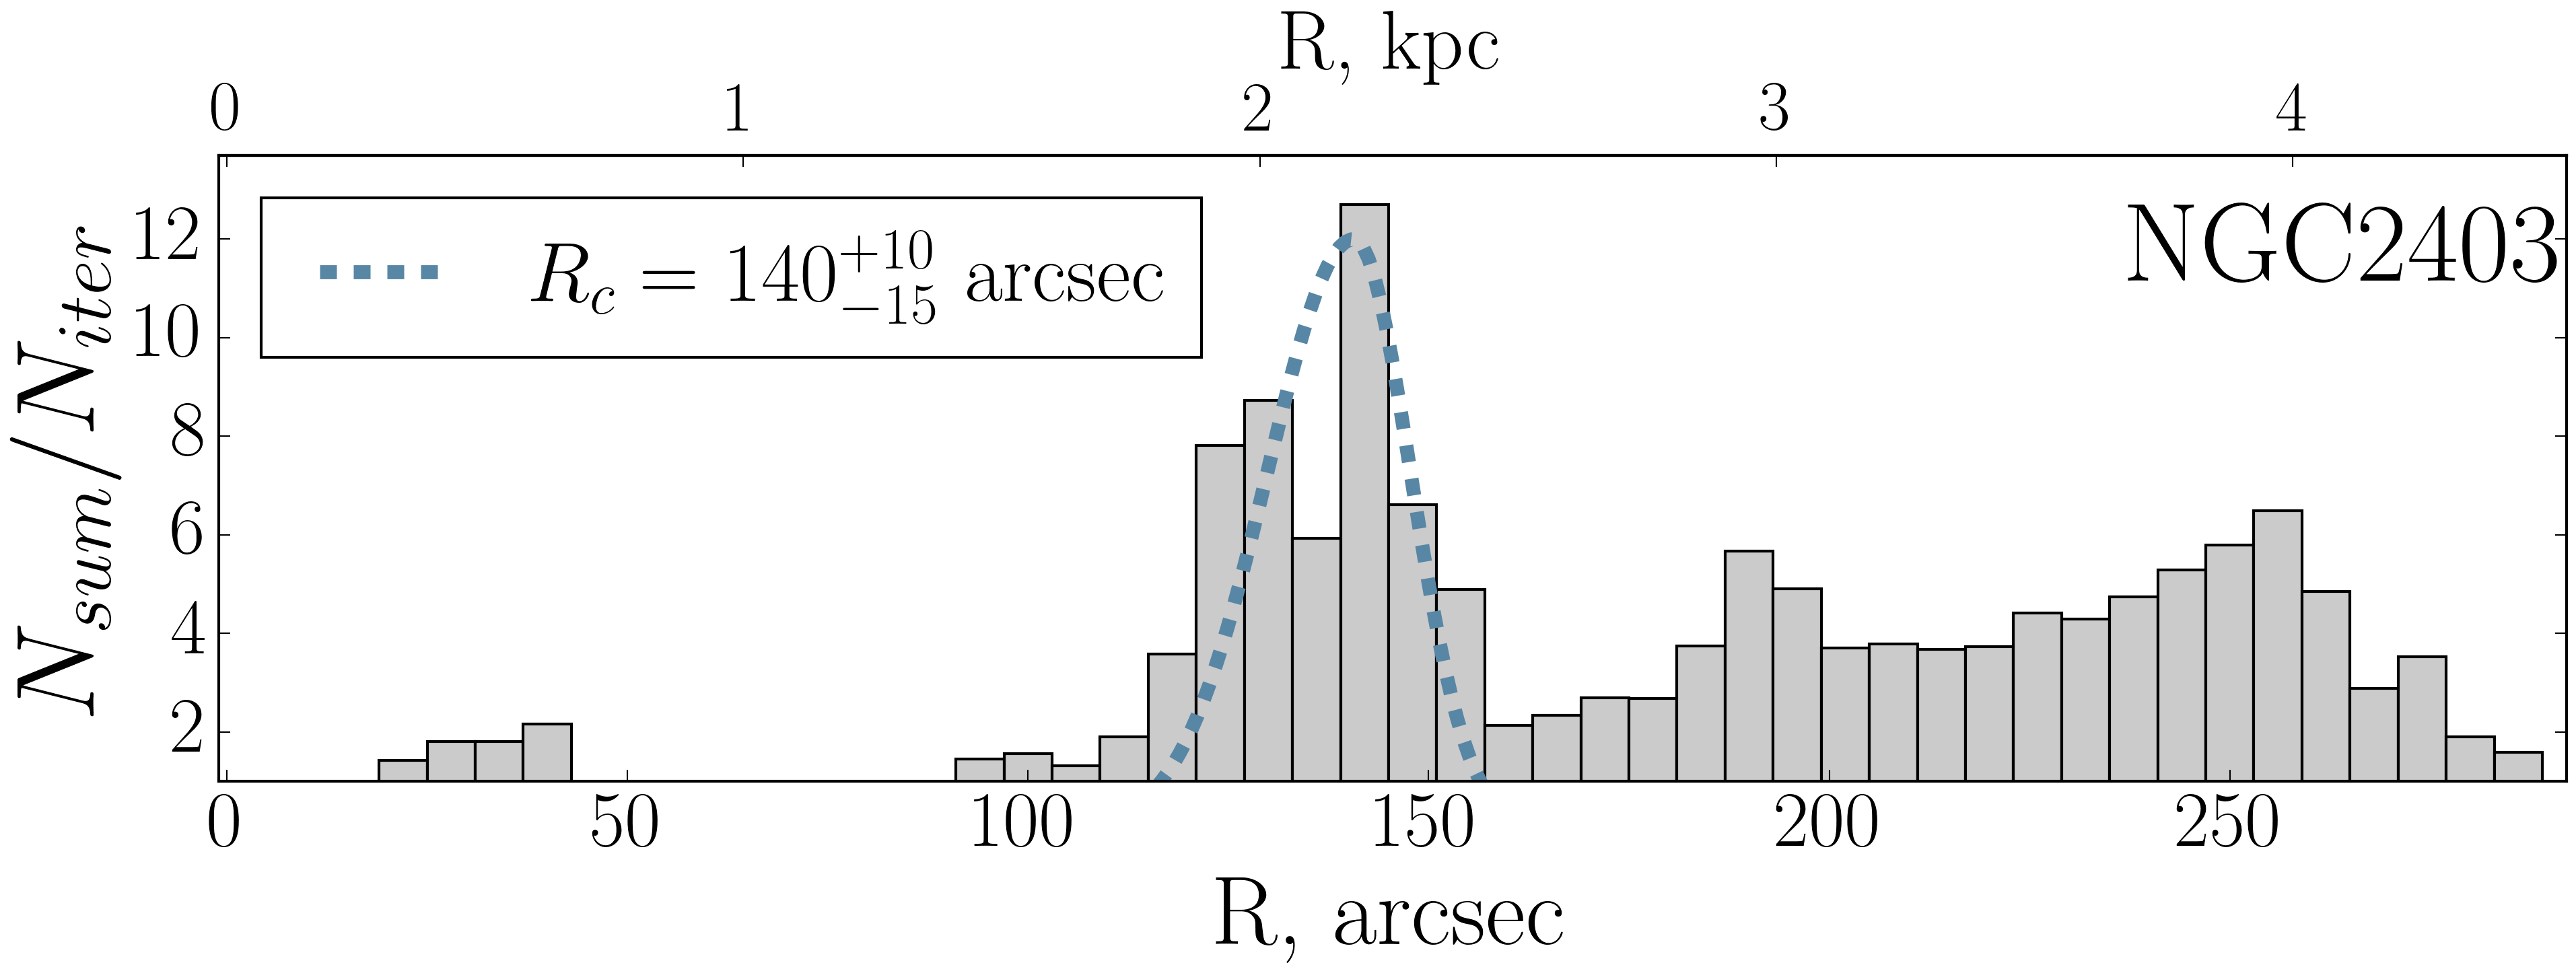

In [5]:
Image('./../methods/F-B method/results_images/NGC2403_F-B.png', width=800)

### metallicity gradient method

In [6]:
def step_funct(x,k1,b1):
    return k1*x+b1


# metallicity data taken from https://ui.adsabs.harvard.edu/abs/2022ApJ...940...32B/abstract
def metal_Bresolin(R_c, err, xlim=None, ax=None, figsize=None, kpc_axis=False):
    
    scale_loc = np.pi / (180 * 3600) * 2.99 * 10**3
    
    metallicity = pd.read_csv('./NGC2403/NGC2403_z.csv',index_col=None) 
    metallicity = metallicity.drop(index=0)
    BA_r = [float(val)/scale_loc  for val in metallicity['BA'].values if float(val)>=0]
    BA_z = [float(val)  for val in metallicity['Unnamed: 1'].values if float(val)<10]
    
    OB_r = [float(val)/scale_loc  for val in metallicity['OB'].values if float(val)>=0]
    OB_z = [float(val)  for val in metallicity['Unnamed: 3'].values if float(val)<10]
    
    HII_r = [float(val)/scale_loc  for val in metallicity['HII'].values if float(val)>=0]
    HII_z = [float(val)  for val in metallicity['Unnamed: 5'].values if float(val)<10]
    
    metal_obs = np.concatenate([BA_z, OB_z, HII_z])
    rad_obs = np.concatenate([BA_r, OB_r, HII_r])
    metal1=[]
    r1=[]
    metal2=[]
    r2=[]
    for i,r in enumerate(rad_obs):
        if r<270:
            r1.append(r)
            metal1.append(metal_obs[i])
        else:
            r2.append(r)
            metal2.append(metal_obs[i])
            
            
    if figsize is not None:
        fig = plt.figure(figsize=figsize)
        plt.xlabel(r'$R$, arcsec', fontsize=35)
        
    if ax is not None:
        ax = ax
    
    param, param_cov = curve_fit(step_funct, r1, metal1)
    points1 = np.linspace(0,270,270)
    step_f1 = [step_funct(x,param[0],param[1]) for x in points1]
    
    param, param_cov = curve_fit(step_funct, r2, metal2)
    points2 = np.linspace(270,650,380)
    step_f2 = [step_funct(x,param[0],param[1]) for x in points2]
    
    param, param_cov = curve_fit(step_funct, rad_obs, metal_obs)
    points = np.linspace(0,600,650)
    step_f = [step_funct(x,param[0],param[1]) for x in points]
     
    plt.plot(points1,step_f1,'--',color='k',lw=3) 
    plt.plot(points2,step_f2,'--',color='k',lw=3)
    plt.plot(points,step_f,':',color='k',lw=3)
    
    if kpc_axis:
        def to_new_axis(x):
            scale = np.pi / (180 * 3600) * Mpc * 10**3
            return x*scale

        def from_new_axis(x):
            scale = np.pi / (180 * 3600) * Mpc * 10**3
            return x/scale
        
        secax = ax.secondary_xaxis('top', functions=(to_new_axis, from_new_axis))
        secax.tick_params(axis='both', which='major', labelsize=20)
        secax.set_xlabel('R, kpc', fontsize=30)
 
    plt.scatter(BA_r,BA_z,[150],marker='o',color='#8ca163', label='BA') 
    plt.scatter(OB_r,OB_z,[150],marker='s',color='#486319', label='OB') 
    plt.scatter(HII_r,HII_z,[50],marker='o',color='#2b3a0f', label='HII')
    plt.xlabel(r'$R$, arcsec', fontsize=35)            
    plt.axvspan(R_c-err,R_c+err,color='#d4e3b2',alpha=0.6)
    plt.tick_params(axis='both', which='major', labelsize=20)  
    plt.ylabel(r'$|z|$', fontsize=35)
    plt.xlim(0,xlim)
    plt.ylim(-0.45,0.09)
    plt.legend(fontsize=23)
    

# metallicity data taken from https://ui.adsabs.harvard.edu/abs/2013ApJ...775..128B/abstract    
def metal_Berg(R_c, err, xlim=None, ax=None, figsize=None, kpc_axis=False):
    
    if figsize is not None:
        fig = plt.figure(figsize=figsize)
        
    if ax is not None:
        ax = ax
        
    data=np.loadtxt('./NGC2403/metal_NGC2403.dat')   
    
    scale_loc = np.pi / (180 * 3600) * 3.16 * 10**3
    
    rad = np.abs(data[:,0])/scale_loc
    abud = np.abs(data[:,1])
    error = np.abs(data[:,1]-data[:,2])
    
    if kpc_axis:
        def to_new_axis(x):
            scale = np.pi / (180 * 3600) * Mpc * 10**3
            return x*scale

        def from_new_axis(x):
            scale = np.pi / (180 * 3600) * Mpc * 10**3
            return x/scale
        
        secax = ax.secondary_xaxis('top', functions=(to_new_axis, from_new_axis))
        secax.tick_params(axis='both', which='major', labelsize=20)
        secax.set_xlabel('R, kpc', fontsize=30)
        
    plt.errorbar(rad, abud, yerr=error,fmt='o',color='#486319')
    plt.ylabel(r'$12+\log(O/H)$', fontsize=30,labelpad=18)
    if figsize is not None:
        plt.xlabel(r'$R$, arcsec', fontsize=35)
    plt.axvspan(R_c-err,R_c+err,color='#d4e3b2',alpha=0.6, label=r'$R_c = 300 \pm 40$"')
    plt.tick_params(axis='both', which='major', labelsize=20)
    plt.xlim(0,xlim)
    plt.ylim(8.12,8.68)
    plt.legend(fontsize=25)
    plt.xticks([]) 

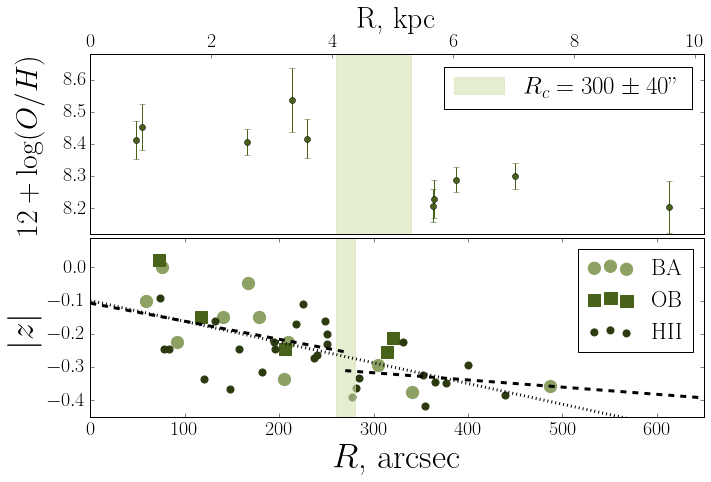

In [7]:
fig = plt.figure(figsize=[11,6.5])
plt.subplots_adjust(wspace=0.02, hspace=0.02)

gs = GridSpec(2, 5, figure=fig)

ax = fig.add_subplot(gs[0, 0:]) 
metal_Berg(300, 40, xlim=650, ax=ax, kpc_axis=True)

ax = fig.add_subplot(gs[1, 0:]) 
metal_Bresolin(270, 10, xlim=650, ax=ax)

plt.savefig('./NGC2403/NGC2403_metallicity.png',transparent = False, dpi=250, bbox_inches='tight', pad_inches=0.05)

-0.00038728118279810164


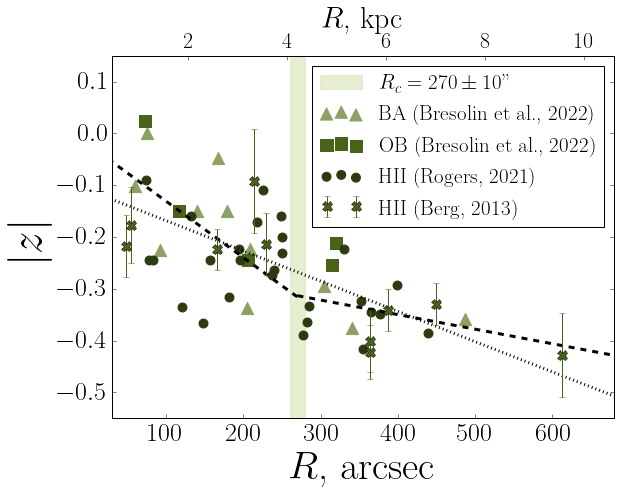

In [19]:
fig, ax = plt.subplots(figsize=[9,6.5])
R_c = 270
err = 10
xlim = 680
########
data_Berg=np.loadtxt('./NGC2403/metal_NGC2403.dat')   
    
scale_loc = np.pi / (180 * 3600) * 3.16 * 10**3
abud_sun = 8.63 #(Allende Prieto et al. 2001)

rad = np.abs(data_Berg[:,0])/scale_loc
abud = np.abs(data_Berg[:,1]) - abud_sun
error = np.abs(data_Berg[:,1]-data_Berg[:,2])



########

scale_loc = np.pi / (180 * 3600) * 2.99 * 10**3
metal_Bresolin = pd.read_csv('./NGC2403/NGC2403_z.csv',index_col=None) 
metal_Bresolin = metal_Bresolin.drop(index=0)
BA_r = [float(val)/scale_loc  for val in metal_Bresolin['BA'].values if float(val)>=0]
BA_z = [float(val)  for val in metal_Bresolin['Unnamed: 1'].values if float(val)<10]

OB_r = [float(val)/scale_loc  for val in metal_Bresolin['OB'].values if float(val)>=0]
OB_z = [float(val)  for val in metal_Bresolin['Unnamed: 3'].values if float(val)<10]

HII_r = [float(val)/scale_loc  for val in metal_Bresolin['HII'].values if float(val)>=0]
HII_z = [float(val)  for val in metal_Bresolin['Unnamed: 5'].values if float(val)<10]

metal_obs = np.concatenate([BA_z, OB_z, HII_z,abud])
rad_obs = np.concatenate([BA_r, OB_r, HII_r,rad])
metal1=[]
r1=[]
metal2=[]
r2=[]
for i,r in enumerate(rad_obs):
    if r<270:
        r1.append(r)
        metal1.append(metal_obs[i])
    else:
        r2.append(r)
        metal2.append(metal_obs[i])
        
param, param_cov = curve_fit(step_funct, r1, metal1)
print(param[0])
points1 = np.linspace(0,270,270)
step_f1 = [step_funct(x,param[0]-0.0007,param[1]+0.11) for x in points1]

param, param_cov = curve_fit(step_funct, r2, metal2)
points2 = np.linspace(270,xlim,380)
step_f2 = [step_funct(x,param[0],param[1]) for x in points2]

param, param_cov = curve_fit(step_funct, rad_obs, metal_obs)
points = np.linspace(0,xlim,xlim)
step_f = [step_funct(x,param[0],param[1]) for x in points]


plt.plot(points1,step_f1,'--',color='k',lw=3) 
plt.plot(points2,step_f2,'--',color='k',lw=3)
plt.plot(points,step_f,':',color='k',lw=3) 

plt.axvspan(R_c-err,R_c+err,color='#d4e3b2',alpha=0.6, label=r'$R_c = 270 \pm 10$"')

plt.scatter(BA_r,BA_z,[150],marker='^',color='#8ca163', label='BA (Bresolin et al., 2022)') 
plt.scatter(OB_r,OB_z,[150],marker='s',color='#486319', label='OB (Bresolin et al., 2022)') 
plt.scatter(HII_r,HII_z,[80],marker='o',color='#2b3a0f', label='HII (Rogers, 2021)')
plt.errorbar(rad, abud, yerr=error,fmt='X',markersize=10,color='#486319', label='HII (Berg, 2013)')

plt.tick_params(axis='both', which='major', labelsize=26,top=False)  
plt.ylabel(r'$|z|$', fontsize=45)
plt.xlabel(r'$R$, arcsec', fontsize=40)
plt.xlim(30,xlim)
plt.ylim(-0.55,0.15)
plt.legend(fontsize=21)

def to_new_axis(x):
    scale = np.pi / (180 * 3600) * Mpc * 10**3
    return x*scale

def from_new_axis(x):
    scale = np.pi / (180 * 3600) * Mpc * 10**3
    return x/scale

secax = ax.secondary_xaxis('top', functions=(to_new_axis, from_new_axis))
secax.tick_params(axis='both', which='major', labelsize=22)
secax.set_xlabel(r'$R$, kpc', fontsize=30)

plt.savefig('./NGC2403/NGC2403_metallicity.png',transparent = False, dpi=200, bbox_inches='tight', pad_inches=0.05, facecolor='white')

### Offset method

see `./../methods/offset_method` for more detail

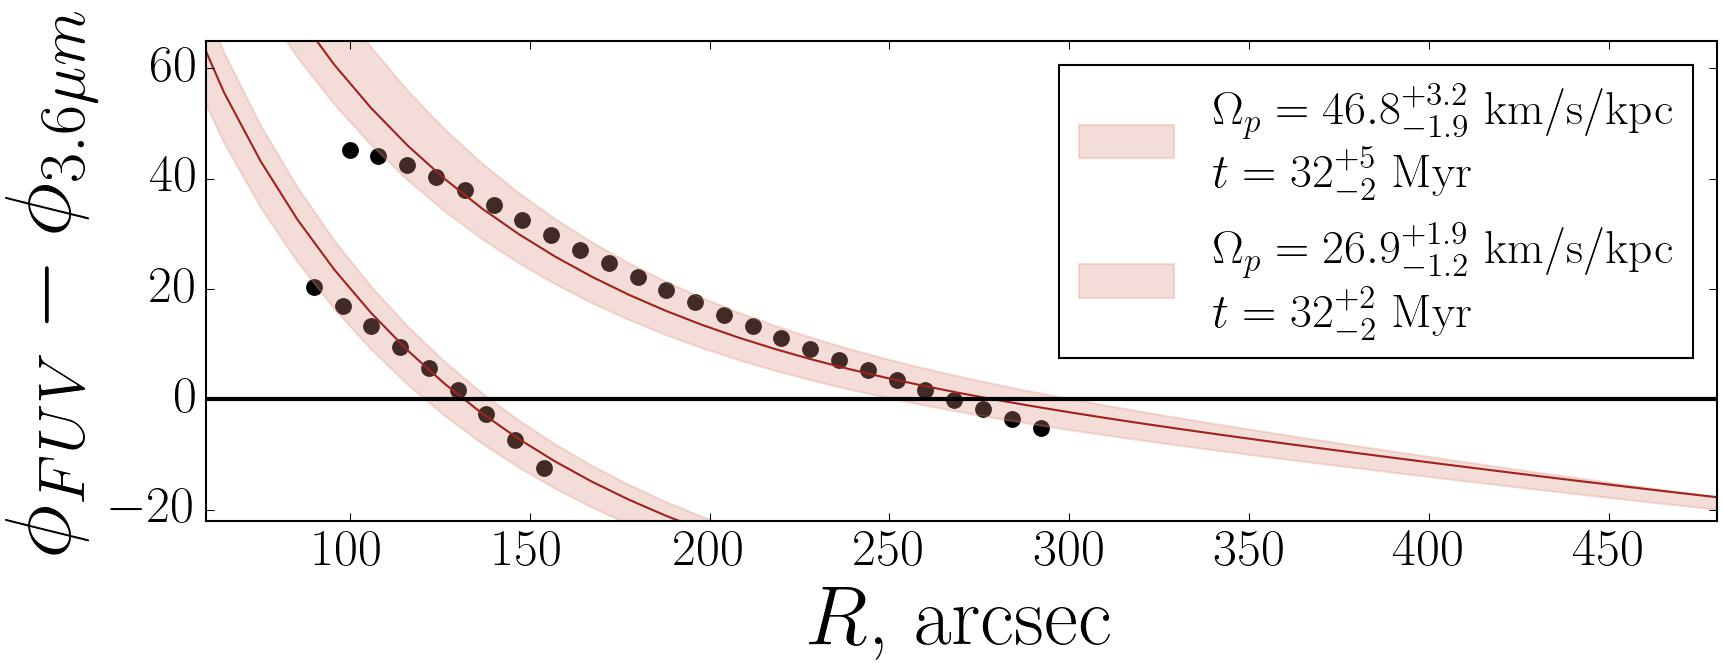

In [55]:
Image('./NGC2403/NGC2403_offset.jpg', width=1000)

In [24]:
# data are taken from Tamburro(2008)
def plot_tamburro(xlim=None, ax=None, figsize=None):
    
    if figsize is not None:
        fig, ax = plt.subplots(figsize=figsize)
        
    if ax is not None:
        ax = ax
                  
    Mpc_loc=3.22
    Omega_p1 = 0.44
    Omega_p2 = 0.70
    t1=1.5
    t2=1.9

    cr1 = 145
    cr2 = 285
    data_offset = np.loadtxt('./NGC2403/NGC2403_offset.dat')

    phi = data_offset[:,1]
    R_kpc =  data_offset[:,0]
    scale_loc = np.pi / (180 * 3600) * Mpc_loc * 10**3
    scale = np.pi / (180 * 3600) * Mpc * 10**3
    R_arcsec = R_kpc/scale_loc

    data = np.loadtxt('./NGC2403/NGC2403_THINGS.dat')

    vel = np.abs(data[:,1])
    
    rad = np.abs(data[:,0])

    velocity_approx = np.poly1d(np.polyfit(rad, vel, deg=5)) 
    points = np.linspace(min(rad), max(rad), 100)
    omega = [v/r for r,v in zip(points, velocity_approx(points))] 
    print(velocity_approx(150)/150)
    
    plt.scatter(R_arcsec, phi,50, marker='s', color='k')
    delta_phi_theor1 = (np.array(omega)/scale-np.array(Omega_p1)/scale)*t1*180./np.pi*0.00102
    delta_phi_theor2 = (np.array(omega)/scale-np.array(Omega_p2)/scale)*t2*180./np.pi*0.00102
    delta_phi_theor1_r = (np.array(omega)/scale-np.array(Omega_p1+0.05)/scale)*(t1)*180./np.pi*0.00102
    delta_phi_theor1_l = (np.array(omega)/scale-np.array(Omega_p1-0.05)/scale)*(t1)*180./np.pi*0.00102
    delta_phi_theor2_r = (np.array(omega)/scale-np.array(Omega_p2+0.1)/scale)*(t2)*180./np.pi*0.00102
    delta_phi_theor2_l = (np.array(omega)/scale-np.array(Omega_p2-0.1)/scale)*(t2)*180./np.pi*0.00102

    plt.axvline(x=cr1, color='#ca6e5e',linestyle='--')
    plt.axvline(x=cr2, color='#ca6e5e',linestyle='--')
    plt.axvspan(cr1-30,cr1+30,color='#ffd7cd',alpha=0.6)
    plt.axvspan(cr2-25, cr2+25,color='#ffd7cd',alpha=0.6)
    plt.fill_between(points,delta_phi_theor1_l ,delta_phi_theor1_r ,color='#dd9181',alpha=0.3)
    plt.fill_between(points,delta_phi_theor2_l ,delta_phi_theor2_r ,color='#dd9181',alpha=0.3)
    plt.plot(points,delta_phi_theor1 , color='#9e221e', label=r'$\Omega_p =$ '+str(int(Omega_p1/scale))+'$\pm$'+str(int(0.06/scale))+' km/s/kpc '+ "\n"+r'($R_c =$'+str(int(cr2))+'$\pm$'+str(int(25))+'") ' + r' $t=1.5$ Myr',lw=2 )
    plt.plot(points,delta_phi_theor2 , color='#9e221e', label=r'$\Omega_p =$ '+str(int(Omega_p2/scale))+'$\pm$'+str(int(0.1/scale))+' km/s/kpc '+ "\n"+r'($R_c =$'+str(int(cr1))+'$\pm$'+str(int(30))+'") ' + r' $t=1.9$ Myr' ,lw=2)


    plt.axhline(y=0, color='black')
    plt.xlabel(r'$R$, arcsec', fontsize=35)
    plt.ylabel(r'$\phi_{24\mu m}-\phi_{HI}$',  fontsize=40)
    plt.legend(fontsize=21)
    plt.tick_params(axis='both', which='major', labelsize=20)
    # ax.text(xlim+30, 14, r'offset', fontsize=25, va='top')
    plt.xlim(0,xlim)
    plt.ylim(-5,15)              
    # plt.savefig('./NGC2403/NGC2403_offset.jpg',transparent = False, dpi=150, bbox_inches='tight', pad_inches=0.05, facecolor='white')

0.6728333705196909


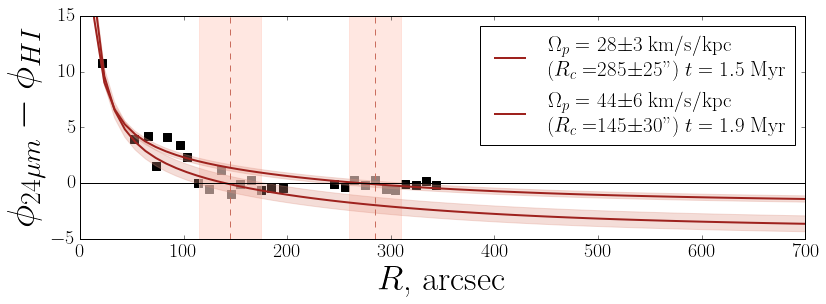

In [25]:
plot_tamburro(xlim=700, ax=None, figsize=[13,4])

### consistent measurements

In [28]:
df = pd.read_csv('./../data/total_crs.csv',index_col=0) 
method_color = {'F-B' : '#354247',
 'F-B (this work)' : '#354247',               
 'P-D' : 'darkslategrey',
 'P-D(bar)' : 'darkslategrey',
 'SNs' : 'lightsalmon',
 'T-W' : 'blue',
 'T-W(bar)' : 'blue',
 'bar-torque' : 'limegreen',
 'gaps(bar)' : 'thistle',
 'gaps' : 'thistle',
 'metallicity' : '#5e7015',               
 'model' : 'magenta',
 'model(bar)' : 'magenta',
 'morph' : 'yellow',                         
 'offset' : 'red',
 'offset (this work)' : 'red',               
 'potential-density' : 'cyan',
 'rings(bar)' : 'sienna',
 'rings' : 'sienna',
 'widths' : 'goldenrod',
 'metallicity (this work)' : '#599e64', 
 'metallicity (McCall, 1982)' : '#1d8427',
 'metallicity (Berg, 2013)' : '#add243',
 'consistent': '#2765a3' }

In [29]:
own_measurements = [[140,10,7,'offset (this work)'],
                    [275,25,25,'offset (this work)'],
                    [270,10,10,'metallicity (this work)'],
                    # [300,40,40,'metallicity (Berg, 2013)'],
                    [140,15,10,'F-B (this work)']]

In [30]:
def assymGauss(x, a, x0, s11, s12):
    test = x<=x0
    P = np.where(test, a*np.exp(-((x-x0)/s11)**2), a*np.exp(-((x-x0)/s12)**2))
    return P

def DoubleGauss(x, a1, x01, s11, s12, a2, x02, s21, s22):
    return assymGauss(x, a1, x01, s11, s12) + assymGauss(x, a2, x02, s21, s22)

def TripleGauss(x, a1, x01, s11, s12, a2, x02, s21, s22, a3, x03, s31, s32):
    return assymGauss(x, a1, x01, s11, s12) + assymGauss(x, a2, x02, s21, s22) + assymGauss(x, a3, x03,  s31, s32)

def QuadrupleGauss(x, a1, x01, s11, s12, a2, x02, s21, s22, a3, x03, s31, s32, a4, x04, s41, s42):
    return assymGauss(x, a1, x01, s11, s12) + assymGauss(x, a2, x02, s21, s22) + assymGauss(x, a3, x03,  s31, s32) + assymGauss(x, a4, x04, s41, s42)

def FitGauss(X,Y,num_Gauss=None,init_approx=None,bounds=None):
    
    if num_Gauss==1:
        p, cov = curve_fit(assymGauss, X, Y, p0=init_approx, bounds=bounds)

    elif num_Gauss==2:
        p, cov = curve_fit(DoubleGauss, X, Y, p0=init_approx, bounds=bounds)
        
    elif num_Gauss==3:
        p, cov = curve_fit(TripleGauss, X, Y, p0=init_approx, bounds=bounds)
        
    elif num_Gauss==4:
        p, cov = curve_fit(QuadrupleGauss, X, Y, p0=init_approx, bounds=bounds)
        
    return p 
def find_reliable_cr(gal_name, add_measure=None, del_measure=None, r_max=None, peak_num=None, cr0=None, show_fit=False, min_err=None, get_params=False, get_curve=False):
    
    altname = Ned.query_object(gal_name)['Object Name']
    cr = []
    cr_r = []
    cr_l = []
    for ind, row in df[df['altname']==altname[0]].iterrows(): 
        if del_measure is not None:
            if row['paper_name'] in del_measure:
                continue
            else:
                cr.append(row['cr']) 
                if row['err_cr_r']>0:
                    crr=row['err_cr_r']
                else:
                    crr=min_err
                if row['err_cr_l']>0:
                    crl=row['err_cr_l']
                else:
                    crl=min_err    
                cr_r.append(crr)
                cr_l.append(crl)
        else:        
            cr.append(row['cr']) 
            if row['err_cr_r']>0:
                crr=row['err_cr_r']
            else:
                crr=min_err
            if row['err_cr_l']>0:
                crl=row['err_cr_l']
            else:
                crl=min_err    
            cr_r.append(crr)
            cr_l.append(crl)
    
    if add_measure is not None:
        for measure in add_measure:
            cr.append(measure[0]) 
            cr_r.append(measure[2])
            cr_l.append(measure[1])

    points = np.linspace(0,r_max,1000)
    F_Gauss = np.zeros(1000)
    for ind in range(len(cr)):
        F_Gauss = F_Gauss + assymGauss(points,1,cr[ind],cr_l[ind],cr_r[ind])
    
    init_approx = []
    bounds_l = []
    bounds_r = []
    for i in range(peak_num):
        init_approx += [1,cr0[i],30,30]
        bounds_l += [1,cr0[i]-20,5,5]
        bounds_r += [5,cr0[i]+20,50,50] 
        
    params = FitGauss(points,F_Gauss,num_Gauss=peak_num,init_approx=init_approx, bounds=[bounds_l,bounds_r])
    crs = np.array(params).reshape((peak_num,4)) 
    print(crs)
    if get_params:
        return crs
    if show_fit:
        fig = plt.figure(figsize=[15,4])
        plt.subplots_adjust(wspace=0.05, hspace=0.1)
        gs = GridSpec(1, 6, figure=fig) 
        ax = fig.add_subplot(gs[0, 0:])
        ax.plot(points,F_Gauss,'--',linewidth=5,color='#5886a5')
        fit_gauss = TripleGauss(points,*params)
        ax.plot(points,fit_gauss,'-',linewidth=3,color='#bd4f4f')
        
    if get_curve:
        fit_gauss = TripleGauss(points,*params)
        return points, fit_gauss

[[  1.97171631 140.05842214  12.563724     8.45497277]
 [  1.9586832  295.00123632  41.13191608  17.17317197]
 [  1.00276446 391.86827584  34.78946975  36.08475808]]


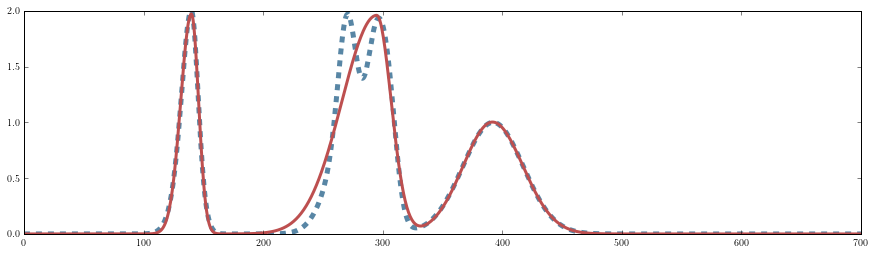

In [31]:
find_reliable_cr('NGC2403',add_measure=own_measurements,del_measure=['Tamburro','Fathi et al. (2009)'],r_max=700,peak_num=3,cr0=[145,285,390],show_fit=True,min_err=10)

In [56]:
def plot_cr_colorlegend(gal_name=None, ax=None, loc=None, fontsize=None, used_methods=None, bars=None):
    if used_methods is None:
        methods = []
        for ind, row in df.iterrows():
            methods.append(row['method'])
        methods = set(methods)
    else:
        for ind,val in enumerate(bars):
            if val=='True':
                meth=used_methods[ind]
                used_methods[ind] = meth+'(bar)'
            methods = set(used_methods)
                
    patches = []
    
    for ind,method in enumerate(methods):
        patch = mpatches.Patch(color=method_color[method], label=method, alpha=0.5)
        patches.append(patch)
    if fontsize is None:
        ax.legend(handles=patches, loc=loc)
        ax.legend(handles=patches, bbox_to_anchor=(1.01,1.2), loc="upper left", 
          fancybox=True, shadow=True, ncol=1)
    else:
        ax.legend(handles=patches, loc="lower right")
        ax.legend(handles=patches, bbox_to_anchor=(1.01,0.96), loc="upper left", fontsize=fontsize,
          fancybox=True, shadow=True, ncol=1, borderaxespad=0.)
        
def plot_crs(gal_name, add_measure=None, del_measure=None,axx=None,legend=True,verbose=False,mode='box',r25=None,
                                             plot_gauss=False,peak_num=None, cr0=None,r_max=None,min_err=None):
    
    if axx is None:
        fig = plt.figure(figsize=[12,3.8])
        ax = plt.gca()
    else:
        ax = axx
        
    ylim = 0
    xlim = 0
    
    ylim_ = 1e10
    xlim_ = 1e10
    
    mets = []
    cc = 0 
    
    altname = Ned.query_object(gal_name)['Object Name']
    cr = []
    cr_r = []
    cr_l = []
    bars = []
    for ind, row in df[df['altname']==altname[0]].iterrows(): 
        if del_measure is not None:
            if row['paper_name'] in del_measure:
                continue
            else:
                cr.append(row['cr']) 
                cr_r.append(row['err_cr_r'])
                cr_l.append(row['err_cr_l'])
                mets.append(row['method']) 
                bars.append(row['bar'])
        else:        
            cr.append(row['cr']) 
            cr_r.append(row['err_cr_r'])
            cr_l.append(row['err_cr_l'])
            mets.append(row['method']) 
            bars.append(row['bar'])
    
    if add_measure is not None:
        for measure in add_measure:
            cr.append(measure[0]) 
            cr_r.append(measure[2])
            cr_l.append(measure[1])
            mets.append(measure[3])
            bars.append('False')
            
    for ind in range(len(cr)):
    
        if verbose:
            print(info, mets[ind])

        if mets[ind] == 'SNs':
            ax.scatter(cr[ind], 50, 100, color=method_color[mets[ind]], label=mets[ind])
        else:
            if mode == 'box':
                ax.axvspan(cr[ind]-abs(cr_l[ind]), cr[ind]+cr_r[ind], alpha=0.5, color=method_color[mets[ind]], label=mets[ind],linewidth = 1)
            else:
                ax.fill_between([cr[ind]-abs(cr_l[ind]), cr[ind]], [0, 100.], alpha=0.4, color=method_color[mets[ind]], label=mets[ind],linewidth=3)
                ax.fill_between([cr[ind],  cr[ind]+cr_r[ind]], [100, 0.], alpha=0.4, color=method_color[mets[ind]], label=mets[ind],linewidth=3)   
            
            ax.scatter(cr[ind], 0, 100, color=method_color[mets[ind]], alpha=1, edgecolor='k',linewidth = 2)
            ax.scatter(cr[ind], 100, 100, color=method_color[mets[ind]], alpha=1, edgecolor='k',linewidth = 2)
            cc+=1
    if verbose:
            print('===='*30)
    if len(cr)==0:
        if verbose:
            print(f'Gal {gal_name} not in entry {ind} ({row["method"]} / {row["link"]}), continue...')
            
    if legend:
        plot_cr_colorlegend(gal_name, ax, loc='lower right', fontsize=20, used_methods=mets, bars=bars)   
    
    if verbose:
           print(f'Gal {gal_name} IN entry {ind} ({row["method"]} / {row["link"]}):')        
    
    # ax.set_title(altname[0]+', number of values: '+str(len(cr_)), fontsize=30,pad=28)
    if axx is None:
        ax.set_xlabel(r'$R$, arcsec', fontsize=35)
        ax.tick_params(axis='both', which='major', labelsize=22,labeltop=False,top=False)  
    else:  
        ax.tick_params(axis='both', which='major', labelsize=22,labeltop=False,top=False,labelbottom=False)  
    ax.set_yticks([])
    ax.set_facecolor('white')
        
    ax.set_ylim(0, 100)
    ax.set_xlim(0, r_max)
    ax.tick_params(axis='both', which='major', labelsize=30,labeltop=False,top=False)  
    
    if plot_gauss:
        points, fit_gauss = find_reliable_cr('NGC2403',add_measure=add_measure,del_measure=del_measure,r_max=r_max,
                                             peak_num=peak_num,cr0=cr0,min_err=min_err,get_curve=True)
        ax.axhline(y=100, color='k',linewidth=2)
        ax.plot(points, fit_gauss*10+101, '-', color='#2765a3',linewidth=2)
        ax.set_ylim(0, 130)
        
    if r25 is not None:
        
        def to_new_axis(x):
            return x/r25
        
        def from_new_axis(x):
            return x*r25
        
        secax = ax.secondary_xaxis('top', functions=(to_new_axis, from_new_axis))
        secax.tick_params(axis='both', which='major', labelsize=22)
        # secax.set_xlabel(r'$R/r_{25}$', fontsize=22)
        # secax.xaxis.set_label_coords(1.05, 2)

[[  1.97171476 140.05853666  12.56385123   8.45486137]
 [  1.95868277 295.00035805  41.13102702  17.17411767]
 [  1.00276514 391.8681675   34.78925394  36.08485715]]


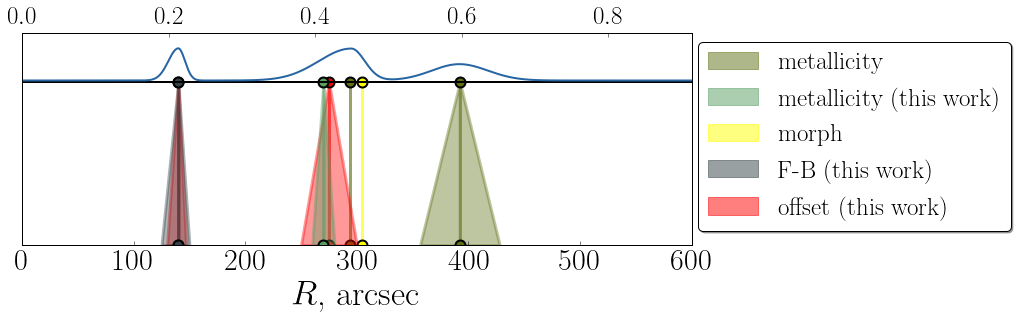

In [44]:
altname = Ned.query_object('NGC2403')['Object Name'][0] 
for ind, row in df[df['altname']==altname].iterrows():
    r25_=row['r25_NED']
plot_crs('NGC2403', add_measure=own_measurements, del_measure=['Tamburro','Fathi et al. (2009)'],axx=None,legend=True,verbose=False,mode=None,r25=r25_,
         plot_gauss=True,peak_num=3, cr0=[145,285,390],r_max=600,min_err=10)

In [57]:
def epic_freq(vel_poly, R):
    return np.sqrt(2.) * vel_poly(R) / R

def velcurve_error(gal_name,vel_curve,deg=None):
    path = vel_curve
    Mpc_loc = 3.22
    scale_loc = np.pi / (180 * 3600) * Mpc_loc * 10**3
     
    data = np.loadtxt(path)
    
    vel = np.abs(data[:,1])
    rad = np.abs(data[:,0])
      
    vel = np.concatenate([[0.0], vel])
    rad = np.concatenate([[0.0], rad])

    points = np.linspace(min(rad), max(rad), 100)
    
    if deg is None:
        velocity_approx = np.poly1d(np.polyfit(rad, vel, deg=7))
    else:
        velocity_approx = np.poly1d(np.polyfit(rad, vel, deg=deg))
    
    flag = True
    error = 0.0
    while flag:
        error+=0.01
        points=0
        for i,r in enumerate(rad):
            if (1.- error) * velocity_approx(r) <= vel[i] <= (1.+ error) * velocity_approx(r):
                points+=1
                
            if points/len(rad) >= 0.65:
                flag=False
        
    return error

def get_Omega_and_error(gal_name,vel_curve,deg=None,inkpc=False,islim=False,add_measure=None,consistent=None,del_measure=None):
    path = vel_curve
    Mpc_loc = 3.22
    scale_loc = np.pi / (180 * 3600) * Mpc_loc * 10**3
     
    data = np.loadtxt(path)
    
    vel = np.abs(data[:,1])
    rad = np.abs(data[:,0])
    
    vel = np.concatenate([[0.0], vel])
    rad = np.concatenate([[0.0], rad])

    points = np.linspace(min(rad)+1, max(rad), 500)
    
    if deg is None:
        velocity_approx = np.poly1d(np.polyfit(rad, vel, deg=7))
    else:
        velocity_approx = np.poly1d(np.polyfit(rad, vel, deg=deg))

    omega = [v/r for r,v in zip(points, velocity_approx(points))]    
    cr = []
    cr_r = []
    cr_l = []
    if consistent is None:
        altname = Ned.query_object(gal_name)['Object Name']
        for ind, row in df[df['altname']==altname[0]].iterrows(): 
            if del_measure is not None:
                if row['paper_name'] in del_measure:
                    continue
                else:
                    cr.append(row['cr']) 
                    cr_r.append(row['cr']+row['err_cr_r'])
                    cr_l.append(row['cr']-row['err_cr_l'])
            else:        
                cr.append(row['cr']) 
                cr_r.append(row['cr']+row['err_cr_r'])
                cr_l.append(row['cr']-row['err_cr_l'])

        if add_measure is not None:
            for measure in add_measure:
                cr.append(measure[0]) 
                cr_r.append(measure[0]+measure[2])
                cr_l.append(measure[0]-measure[1])
    else:
        for string in consistent:
            cr.append(string[1])
            cr_r.append(string[1]+string[3]/1.5)
            cr_l.append(string[1]-string[2]/1.5)
    
    Omega = []
    Omega_l = []
    Omega_r = []
    vel_err = velcurve_error(gal_name,vel_curve,deg=deg) 

    if islim:
        for i, r in enumerate(cr):
            if(r<=max(rad)):
                errors=[]
                Omega.append(velocity_approx(r)/r)
                errors.append(velocity_approx(cr_l[i])/cr_l[i])
                errors.append((1.+vel_err)*velocity_approx(cr_l[i])/cr_l[i])
                errors.append((1.-vel_err)*velocity_approx(cr_l[i])/cr_l[i])
                errors.append(velocity_approx(cr_r[i])/cr_r[i])
                errors.append((1.+vel_err)*velocity_approx(cr_r[i])/cr_r[i])
                errors.append((1.-vel_err)*velocity_approx(cr_r[i])/cr_r[i])
                Omega_l.append(np.min(errors))
                Omega_r.append(np.max(errors))
    else:
        for i, r in enumerate(cr):
            errors=[]
            Omega.append(velocity_approx(r)/r)
            errors.append(velocity_approx(cr_l[i])/cr_l[i])
            errors.append((1.+vel_err)*velocity_approx(cr_l[i])/cr_l[i])
            errors.append((1.-vel_err)*velocity_approx(cr_l[i])/cr_l[i])
            errors.append(velocity_approx(cr_r[i])/cr_r[i])
            errors.append((1.+vel_err)*velocity_approx(cr_r[i])/cr_r[i])
            errors.append((1.-vel_err)*velocity_approx(cr_r[i])/cr_r[i])
            Omega_l.append(np.min(errors))
            Omega_r.append(np.max(errors))
                  

    err_l = [Omega[i] - Omega_l[i] for i in range(len(Omega))]
    err_r =  [Omega_r[i] - Omega[i] for i in range(len(Omega))]

    if inkpc:
        scale = np.pi / (180 * 3600) * Mpc * 10**3
        Omega = np.array(Omega) / scale_loc
        err_l = np.array(err_l) / scale_loc
        err_r = np.array(err_r) / scale_loc
        Omega = Omega.tolist()
        err_l = err_l.tolist()
        err_r = err_r.tolist()
        return  Omega, err_l, err_r
    else:
        return  Omega, err_l, err_r
            
def plot_Omega(gal_name,vel_curve,deg=None,figsize=None,ax=None,add_measure=None,consistent=None,del_measure=None,xlim=None,cross_reson=None): 
    
    path = vel_curve
    Mpc_loc = 3.22
    scale_loc = np.pi / (180 * 3600) * Mpc_loc * 10**3
     
    data = np.loadtxt(path)
    
    vel = np.abs(data[:,1])
    rad = np.abs(data[:,0])
    
    vel = np.concatenate([[0.0], vel])
    rad = np.concatenate([[0.0], rad])
            
    cr = []
    method = []
    if consistent is None:
        altname = Ned.query_object(gal_name)['Object Name']
        for ind, row in df[df['altname']==altname[0]].iterrows(): 
            if del_measure is not None:
                if row['paper_name'] in del_measure:
                    continue
                else:
                    cr.append(row['cr']) 
                    method.append(row['method'])
            else:        
                cr.append(row['cr'])
                method.append(row['method'])

        if add_measure is not None:
            for measure in add_measure:
                cr.append(measure[0])
                method.append(measure[3])
    else:
        for string in consistent:
            cr.append(string[1])
            method.append('consistent')

    points = np.linspace(min(rad), xlim,500)
    if deg is None:
        velocity_approx = np.poly1d(np.polyfit(rad, vel, deg=7))
    else:
        velocity_approx = np.poly1d(np.polyfit(rad, vel, deg=deg))
    
    err = velcurve_error(gal_name,vel_curve,deg=deg)     
    scale = np.pi / (180 * 3600) * Mpc * 10**3
    
    kappa = [epic_freq(velocity_approx, r)/scale for r in points]
    kappa_l = [epic_freq((1.-err)*velocity_approx, r)/scale for r in points]
    kappa_r = [epic_freq((1.+err)*velocity_approx, r)/scale for r in points]
    
    omega = [v/r/scale for r,v in zip(points, velocity_approx(points))] 
    omega_l = [v/r/scale for r,v in zip(points, (1.-err)*velocity_approx(points))]  
    omega_r = [v/r/scale for r,v in zip(points, (1.+err)*velocity_approx(points))]  
      
    if figsize is not None:
        fig = plt.figure(figsize=figsize)
        
    if ax is not None:
        ax = ax
        
    plt.plot(points, omega, color='k',linewidth=3)
    plt.fill_between(points,omega_l, omega_r, alpha=0.6,color='lightgray')
    
    plt.plot(points, np.array(omega)-np.array(kappa)/2.,'-.', color='k',linewidth=2)
    plt.fill_between(points, np.array(omega_l)-np.array(kappa_l)/2., np.array(omega_r)-np.array(kappa_r)/2., alpha=0.4,color='lightgray')
    
    plt.plot(points, np.array(omega)+np.array(kappa)/2.,'-.', color='k',linewidth=2)
    plt.fill_between(points,np.array(omega_l)+np.array(kappa_l)/2., np.array(omega_r)+np.array(kappa_r)/2., alpha=0.4,color='lightgray')
    
    plt.plot(points, np.array(omega)-np.array(kappa)/4., ':', color='k', alpha=0.9)
    plt.fill_between(points, np.array(omega_l)-np.array(kappa_l)/4., np.array(omega_r)-np.array(kappa_r)/4., alpha=0.4,color='lightgray')
    plt.plot(points, np.array(omega)+np.array(kappa)/4., ':', color='k', alpha=0.9)
    plt.fill_between(points,np.array(omega_l)+np.array(kappa_l)/4., np.array(omega_r)+np.array(kappa_r)/4., alpha=0.4,color='lightgray')
    
    Omega, err_l, err_r = get_Omega_and_error(gal_name,vel_curve,deg=deg,inkpc=True,add_measure=add_measure,consistent=consistent,del_measure=del_measure)
            
    if len(cr) != 0:
        array = zip(Omega,err_l,err_r, cr, method)
        array_sort = sorted(array, key=lambda tup: tup[0],reverse=True)
        Omega = [x[0] for x in array_sort]
        err_l = [x[1] for x in array_sort]
        err_r = [x[2] for x in array_sort]
        cr = [x[3] for x in array_sort]
        method = [x[4] for x in array_sort]
        y_new=0
        
        for ind,val in enumerate(cr):
            if (val<=xlim):                 
                plt.plot([val], [Omega[ind]], 'o',color=method_color[method[ind]])
                
                plt.axhspan(Omega[ind]-err_l[ind],Omega[ind]+err_r[ind], alpha=0.25,color=method_color[method[ind]],
                           label = r'$\Omega_p = $'+str("%.1f"%Omega[ind])+'$^{+'+str("%.1f"%err_r[ind])+'}_{-'+str("%.1f"%err_l[ind])+'}$ km/s/kpc'+'\n'+'('+ str("%.0f"% val)+' arcsec)')        
                
                if cross_reson is not None:
                    if cross_reson[ind] == 2:
                        xx,yy = np.array(omega)+np.array(kappa)/2., points
                    elif  cross_reson[ind] == 4:
                        xx,yy = np.array(omega)+np.array(kappa)/4., points
                else:        
                    xx,yy = np.array(omega)+np.array(kappa)/2., points
                indxs = np.isfinite(xx)
                xx,yy = xx[indxs], yy[indxs]

                shapely_line = LineString([[y,x] for x,y in zip(xx, yy)])
                hor_line = LineString([[-1000, Omega[ind]], [1000, Omega[ind]]])
                intersection_line = shapely_line.intersection(hor_line)
            
                try:
                    if len(intersection_line.coords) != 0:
                        if type(intersection_line) == shapely.geometry.multipoint.MultiPoint:
                            y_new = [(pt.x, pt.y) for pt in intersection_line][1][0]
                        else:
                            y_new = intersection_line.xy[0][0]
                
                        plt.plot([val, y_new], [Omega[ind], Omega[ind]], 's-', mec='k',color=method_color[method[ind]],linewidth = 3)
                        plt.plot([y_new, y_new], [0, Omega[ind]], '--', alpha=0.7,color=method_color[method[ind]],linewidth = 4) 
                except:
                    if type(intersection_line) == shapely.geometry.multipoint.MultiPoint:
                            y_new = [(pt.x, pt.y) for pt in intersection_line][1][0]
                    else:
                            y_new = intersection_line.xy[0][0]
                
                    plt.plot([val, y_new], [Omega[ind], Omega[ind]], 's-', mec='k',color=method_color[method[ind]],linewidth = 3)
                    plt.plot([y_new, y_new], [0, Omega[ind]], '--', alpha=0.7,color=method_color[method[ind]],linewidth = 4) 
                
            
            
   
    plt.legend(bbox_to_anchor=(1.01,0.95), loc="upper left", fontsize=20,
         fancybox=True, shadow=True, ncol=1, borderaxespad=0.)
    
    # plt.plot([190, 190], [0, 0.595], '--', alpha=0.7,color='#354247',linewidth = 4) 
    # plt.plot([190, 310], [0.391, 0.391], 's-', alpha=0.99,color='#ee4b48',linewidth = 4) 
    
    plt.xlim(0,xlim) 
    plt.ylim(0,1.4*(Omega[0]+err_l[0]))
    plt.ylabel(f'$\Omega$, km/s/kpc', fontsize = 40)
    plt.xlabel(f'$R$, arcsec', fontsize = 40) 
    plt.tick_params(axis='both', which='major',labelsize=28)

[[  1.97171276 140.05863612  12.56397084   8.45475273]
 [  1.95868142 294.9995594   41.13023904  17.17498429]
 [  1.00276574 391.86806918  34.78905937  36.08494742]]


[[  1.97171276 140.05863612  12.56397084   8.45475273]
 [  1.95868142 294.9995594   41.13023904  17.17498429]
 [  1.00276574 391.86806918  34.78905937  36.08494742]]


/tmp/ipykernel_12054/795710988.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(2.) * vel_poly(R) / R
/tmp/ipykernel_12054/795710988.py:186: RuntimeWarning: divide by zero encountered in double_scalars
  omega = [v/r/scale for r,v in zip(points, velocity_approx(points))]
/tmp/ipykernel_12054/795710988.py:187: RuntimeWarning: divide by zero encountered in double_scalars
  omega_l = [v/r/scale for r,v in zip(points, (1.-err)*velocity_approx(points))]
/tmp/ipykernel_12054/795710988.py:188: RuntimeWarning: divide by zero encountered in double_scalars
  omega_r = [v/r/scale for r,v in zip(points, (1.+err)*velocity_approx(points))]
/tmp/ipykernel_12054/795710988.py:199: RuntimeWarning: invalid value encountered in subtract
  plt.plot(points, np.array(omega)-np.array(kappa)/2.,'-.', color='k',linewidth=2)
/tmp/ipykernel_12054/795710988.py:200: RuntimeWarning: invalid value encountered in subtract
  plt.fill_between(points, np.array(omega_l)-np.array(kappa_l)

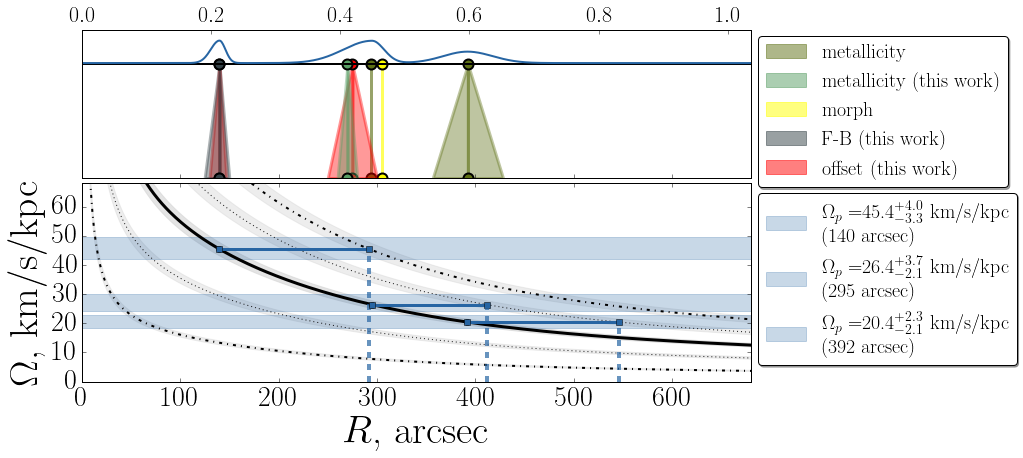

In [58]:
crs = find_reliable_cr('NGC2403',add_measure=own_measurements,del_measure=['Tamburro','Fathi et al. (2009)'],r_max=680,peak_num=3,cr0=[145,295,390],min_err=10,get_params=True)

fig = plt.figure(figsize=[12,6.3])
plt.subplots_adjust(wspace=0.05, hspace=0.1)

gs = GridSpec(7, 5, figure=fig)

ax = fig.add_subplot(gs[0:3, 0:]) 
altname = Ned.query_object('NGC2403')['Object Name'][0]    
for ind, row in df[df['altname']==altname].iterrows():
    r25_=row['r25_NED']

plot_crs('NGC2403', add_measure=own_measurements, del_measure=['Tamburro','Fathi et al. (2009)'],axx=ax,legend=True,verbose=False,mode=None,r25=r25_,
         plot_gauss=True,peak_num=3, cr0=[145,295,390],r_max=680,min_err=10)

#######
ax = fig.add_subplot(gs[3:, 0:]) 
plot_Omega('NGC2403','./NGC2403/NGC2403_THINGS.dat',deg=5,ax=ax,consistent=crs,xlim=680,cross_reson=[2,4,4])
plt.savefig('./NGC2403/NGC2403_consistency.jpg',transparent = False, dpi=150, bbox_inches='tight', pad_inches=0.05, facecolor='white')

### Additional evidence

#### Image

([], [])

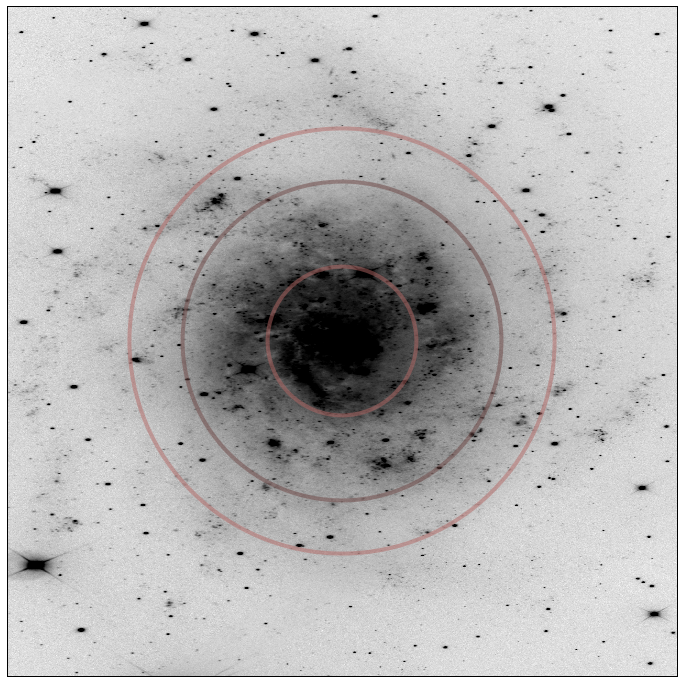

In [59]:
data = fits.getdata("./NGC2403/NGC2403_SDSS_g_rot.fits")
data = np.squeeze(data)
N=2800

shape = data.shape

size2 = [N,N]
size2_ = u.Quantity(size2, u.pixel)
data_SDSS = Cutout2D(data.data, (int(shape[1]/2),int(shape[0]/2)) , size2_, mode='partial', fill_value=0.)


plt.figure(figsize=[12, 12])
quadmesh = plt.pcolormesh(np.log10(data_SDSS.data), cmap='gist_yarg')
quadmesh.set_clim( vmin=-6.4,vmax=-5.4)
# plt.colorbar()

shape_ = data_SDSS.shape

R_1 = 140./0.45

circle1=plt.Circle((int(shape_[0]/2),int(shape_[1]/2)),R_1,color='#b36764',alpha=0.5, lw=4,fill=False, label = r'$149$ arcsec')
plt.gcf().gca().add_artist(circle1)

R_2 = 300./0.45
circle2=plt.Circle((int(shape_[0]/2),int(shape_[1]/2)),R_2,color='#6d4543',alpha=0.5, lw=4,fill=False, label = r'$287$ arcsec')
plt.gcf().gca().add_artist(circle2)

R_3 = 400./0.45
circle3=plt.Circle((int(shape_[0]/2),int(shape_[1]/2)),R_3,color='#b36764',alpha=0.5, lw=4,fill=False, label = r'$550$ arcsec')
plt.gcf().gca().add_artist(circle3)


plt.xticks([])
plt.yticks([])


#### Surface brightness profile

In [9]:
Distance = Mpc
cosi=np.cos(60 / 180. * np.pi)

In [10]:
def cut_fits(first_fits=None, second_fits=None, size=None,galname=None):
    RA = Ned.query_object(galname)['RA']
    DEC = Ned.query_object(galname)['DEC']
    cposition = SkyCoord('{} {}'.format(RA[0],DEC[0]),  frame='icrs', unit='deg')
    
    first_data = fits.getdata(first_fits)
    first_data = np.squeeze(first_data)
    first_WCS = WCS(first_fits, naxis = 2) 
        
    second_data = fits.getdata(second_fits)
    second_data = np.squeeze(second_data)
    second_WCS = WCS(second_fits, naxis = 2)
    
    size = u.Quantity(size, u.arcsec)
    
    first_data = Cutout2D(first_data, cposition, size, wcs=first_WCS, mode='partial', fill_value=0.)
    second_data = Cutout2D(second_data, cposition, size, wcs=second_WCS, mode='partial', fill_value=0.)
    
    return first_data, second_data  

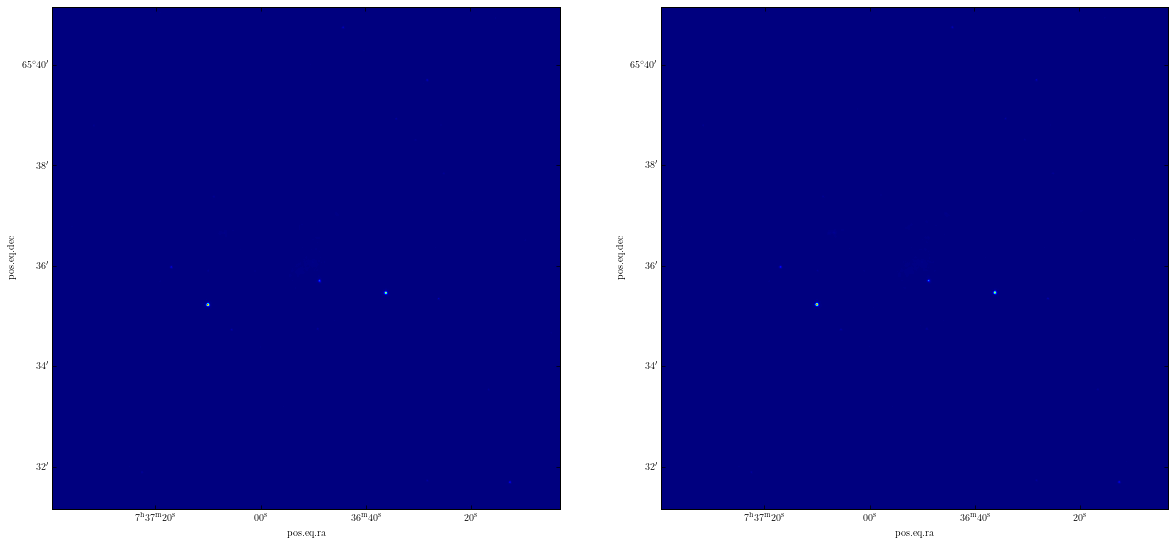

(800, 800)
(800, 800)


In [14]:
size=[600,600]
I_36, I_45 = cut_fits(first_fits = './NGC2403/NGC2403_3.6.fits', second_fits ='./NGC2403/NGC2403_4.5.fits', size = size, galname='NGC2403') 
fig = plt.figure(figsize=[20, 9])
ax = fig.add_subplot(121, projection=I_36.wcs)

ax.imshow(I_36.data, origin='lower', aspect="auto")

ax2 = fig.add_subplot(122, projection=I_45.wcs)
ax2.imshow(I_45.data, origin='lower', aspect="auto")

plt.show()

print(I_36.shape)
print(I_45.shape)  

In [15]:
I_36_Jy= np.array(I_36.data).reshape(I_36.shape)
I_45_Jy= np.array(I_45.data).reshape(I_45.shape)
# from MJy/ster to Jy
F_36 = I_36_Jy * 10**6 * (0.75 * np.pi / 180 / 3600)**2
F_45 = I_45_Jy * 10**6 * (0.75 * np.pi / 180 / 3600)**2

M_star = np.power(10,8.35,dtype = float) * np.power(F_36,1.85,dtype = float) * np.power(F_45,-0.85,dtype = float) * Distance**2 *cosi
pc_arcsec = (Distance*10**6*2*np.pi)/(360*60*60.)
arcsec_pix = 0.75
pixel_size = pc_arcsec * arcsec_pix
Sigma_s = M_star/pixel_size**2

/tmp/ipykernel_11286/2820567416.py:7: RuntimeWarning: invalid value encountered in power
  M_star = np.power(10,8.35,dtype = float) * np.power(F_36,1.85,dtype = float) * np.power(F_45,-0.85,dtype = float) * Distance**2 *cosi


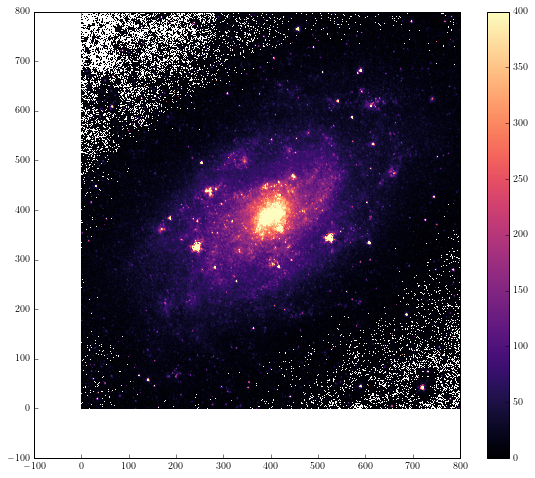

In [19]:
fig = plt.figure(figsize = [21,8])
ax1 = fig.add_subplot(121)
X, Y = np.meshgrid(np.arange(0,800,1), np.arange(0,800,1))
quadmesh = plt.pcolormesh(X, Y,Sigma_s, cmap='magma')
quadmesh.set_clim(vmin=0., vmax=400.)
plt.colorbar()

In [20]:
fits.PrimaryHDU(data=Sigma_s).writeto('./NGC2403/Sigma_s.fits', overwrite=True)


In [21]:
import zoomdown

In [37]:
def get_profile(galname,fits_file=None,incl=None,PA=None,dist_max=None,zoom_down=None):
    
#     RA = Ned.query_object(galname)['RA']
#     DEC = Ned.query_object(galname)['DEC']
#     cposition = SkyCoord('{} {}'.format(RA[0],DEC[0]), frame='icrs', unit='deg', equinox='J2000.0')
#     data =  WCS(fits_file, naxis = 2)
#     x0,y0 = skycoord_to_pixel(cposition,data)
    
#     shiftdeg = pixel_to_skycoord(x0,y0-1,data)
#     resol = abs(shiftdeg.dec.arcsec-cposition.dec.arcsec) #find pixel size
#     print(resol)
    resol=0.75
    cosi = np.cos(incl*np.pi/180.)
    PA = PA*np.pi/180.
    
    data = fits.getdata(fits_file)
    x0,y0 = data.shape[0]/2,data.shape[1]/2
    data = np.squeeze(data)
    
    if zoom_down is not None:
        # size = u.Quantity([dist_max*1.2/resol,dist_max*1.2/resol], u.pixel)
        # data_cut = Cutout2D(data.data, (x0,y0) , size, mode='partial', fill_value=0.)
        data_zoom = zoomdown.zoomdown(data,zoom_down)
        print('done')
        resol = resol/zoom_down
        x0 = data_zoom.shape[0]/2
        y0 = data_zoom.shape[0]/2
        data_zoom = data_zoom*zoom_down**2
    else:
        data_zoom = data
        
    data_dist = np.zeros(data_zoom.shape)
    data_bright = np.zeros(data_zoom.shape)

    
    X,Y = np.meshgrid(np.arange(0,data_zoom.shape[1], 1), np.arange(0,data_zoom.shape[0], 1))
    X_shift = X - x0
    Y_shift = Y - y0 
    X_rot = Y_shift * np.cos(PA) + X_shift * np.sin(PA)
    Y_rot0 =  -Y_shift * np.sin(PA) + X_shift * np.cos(PA)
    Y_rot = Y_rot0/cosi
    R = np.sqrt(X_rot**2 + Y_rot**2)*resol

    cut = (R<dist_max)

    data_bright = data_zoom[cut]
    data_dist = R[cut]

    return data_bright,data_dist


In [52]:
data_bright,data_dist = get_profile('NGC2403',fits_file='./NGC2403/Sigma_s.fits',incl=60,PA=125,dist_max=650,zoom_down=0.6)



done


/tmp/ipykernel_11286/138935967.py:3: RuntimeWarning: divide by zero encountered in divide
  hist_norm = hist.T/(2*np.pi*x_h[:-1])
/tmp/ipykernel_11286/138935967.py:3: RuntimeWarning: invalid value encountered in divide
  hist_norm = hist.T/(2*np.pi*x_h[:-1])
/tmp/ipykernel_11286/138935967.py:5: RuntimeWarning: divide by zero encountered in log10
  pcm = ax0.pcolormesh(x_h[:-1], y_h[:-1],np.log10(hist.T),cmap = "inferno")
/tmp/ipykernel_11286/138935967.py:7: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("inferno").copy()
  pcm.cmap.set_under('#21041f')
/tmp/ipykernel_11286/138935967.py:8: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be ab

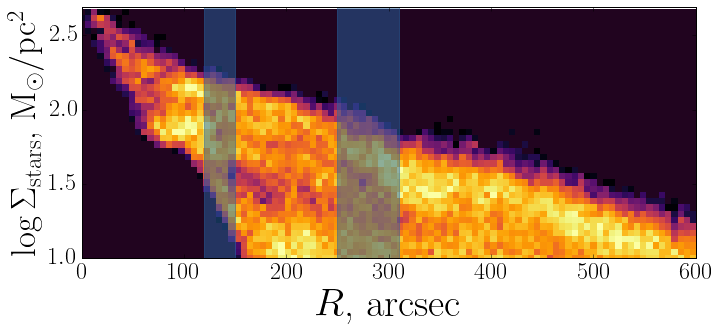

In [62]:
fig, ax0 = plt.subplots(ncols=1, sharey=True, figsize=(11, 4.5))
hist, x_h, y_h = np.histogram2d(data_dist,np.log10(data_bright),range=[[0,610],[1.,2.7]],bins=[100,40])
hist_norm = hist.T/(2*np.pi*x_h[:-1])

pcm = ax0.pcolormesh(x_h[:-1], y_h[:-1],np.log10(hist.T),cmap = "inferno")
pcm.set_clim( vmin=1.2, vmax=2.1)
pcm.cmap.set_under('#21041f')
pcm.cmap.set_bad('#21041f')
# fig.colorbar(pcm, ax=ax0, pad=0)
ax0.set_xlim(0,600)
ax0.set_ylim(1.,2.69)
plt.xlabel(r'$R$, arcsec', fontsize=40)
plt.ylabel(r'$\log \Sigma_{\rm stars}$, $\rm M_\odot/ \rm pc^2$', fontsize=35)
plt.tick_params(axis='both', which='major',labelsize=24)
plt.axvspan(120,150, alpha=0.5,color='#2765a3')
plt.axvspan(250,310, alpha=0.5,color='#2765a3')
plt.savefig('./NGC2403/NGC2403_profile.jpg',transparent = False, dpi=150, bbox_inches='tight', pad_inches=0.05, facecolor='white')

### Fourier

/tmp/ipykernel_12054/2689616225.py:7: RuntimeWarning: invalid value encountered in divide
  plt.plot(mI[1:, 1] * 2.3 * 0.262 , mI[1:, 3]/m0[1:, 3], label=f'm{m}/m0',lw=2.5,color=colors[m-1])


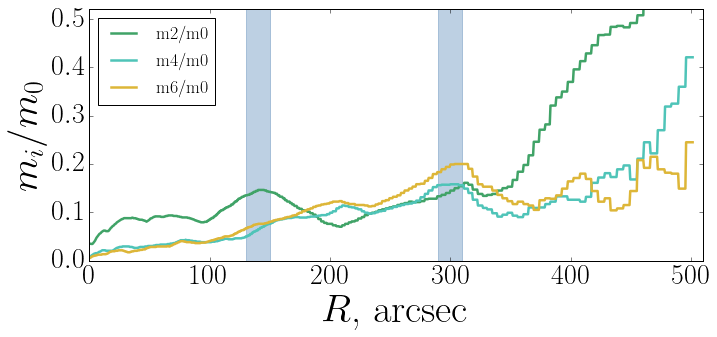

In [70]:
name='NGC2403'
fig = plt.figure(figsize=[11, 4.5])
m0 = np.loadtxt(f'./{name}/{name}_fourier/{name}_dr8_g_deproject_m0')
colors=['#1d77c4','#40a367','#c43737','#4fc4b8','#a85bc4','#ddb638']
for m in [2,4,6]:
    mI = np.loadtxt(f'./{name}/{name}_fourier/{name}_dr8_g_deproject_m{m}')
    plt.plot(mI[1:, 1] * 2.3 * 0.262 , mI[1:, 3]/m0[1:, 3], label=f'm{m}/m0',lw=2.5,color=colors[m-1])

plt.legend(loc='upper left',fontsize=18)
plt.xlim(0,510)
plt.ylim(0,0.52)
plt.xlabel(r'$R$, arcsec', fontsize=40)
plt.ylabel(r'$m_i/m_0$', fontsize=40)
plt.tick_params(axis='both', which='major',labelsize=28)
plt.axvspan(130,150, alpha=0.3,color='#2765a3')
plt.axvspan(290,310, alpha=0.3,color='#2765a3')
plt.savefig('./NGC2403/NGC2403_fourier.jpg',transparent = False, dpi=150, bbox_inches='tight', pad_inches=0.05, facecolor='white')